<a href="https://colab.research.google.com/github/williamtovar/pix2pixCSV/blob/master/pix2pix_Draws.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GPU libre

In [1]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp37-none-any.whl size=7411 sha256=581c9f571572a13fe149e1b0ddbfd827c0f33f1207f2e3b8374e5a8b26563c2a
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 118.1 MB
GPU RAM Free: 15109MB | Used: 0MB | Util   0% | Total 15109MB


Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Codigo para importar variables

In [3]:
%tensorflow_version 2.x

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

path="/content/drive/My Drive/ConcursoDotCSV"
pathx=path+'/imgs/imgs_X3'
pathy=path+'/imgs/imgs_Y'
pathc=path+'/checkpoints'

imgurls=!ls -1 "{pathx}"
#imgurls

In [5]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

1225 240 60


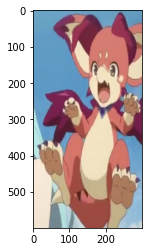

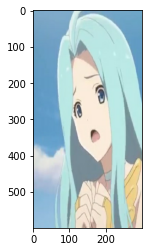

In [6]:
n=300
train_n=round(n*0.80)

#------------------------------
inp, re = load(pathy+'/img_10002.jpg')
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)
#--------------------------------------
#Listado random
randurls=np.copy(imgurls)

np.random.shuffle(randurls)

#Particion train/test
tr_urls=randurls[:train_n]
ts_urls=randurls[train_n:n]

print(len(imgurls),len(tr_urls),len(ts_urls))


In [7]:
IMG_W=256
IMG_H=256

def resize(inimg,tgimg, h, w):
  inimg=tf.image.resize(inimg,[h,w])
  tgimg=tf.image.resize(tgimg,[h,w])
  
  return inimg,tgimg

#Noramlizar al rango -1,1
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_H, IMG_W, 3])

  return cropped_image[0], cropped_image[1]

In [8]:
#Random litter--- aumentar dataset
@tf.function()
def random_jitter(inimg, tgimg):
  
  inimg,tgimg = resize(inimg,tgimg, 600, 600)
  
  stacked_image=tf.stack([inimg,tgimg],axis=0)
  cropped_image=tf.image.random_crop(stacked_image, size=[2,IMG_H,IMG_W,3])
  
  inimg, tgimg = cropped_image[0],cropped_image[1]
  
  if tf.random.uniform(()) > 0.5:
    # random mirroring
    inimg = tf.image.flip_left_right(inimg)
    tgimg = tf.image.flip_left_right(tgimg)

  return inimg, tgimg 

In [9]:
def load_image(filename, augment=True):
  inimg=tf.cast(tf.image.decode_jpeg(tf.io.read_file(pathx+'/'+filename)),tf.float32)[..., :3]
  tgimg=tf.cast(tf.image.decode_jpeg(tf.io.read_file(pathy+'/'+filename)),tf.float32)[..., :3]
  
    
  if augment:
    inimg, tgimg=random_jitter(inimg,tgimg)
  else:
    inimg, tgimg=resize(inimg,tgimg,IMG_H,IMG_W)
    
  inimg, tgimg=normalize(inimg,tgimg)
  return inimg, tgimg

def load_train_image(filename):
  return load_image(filename,False)

def load_test_image(filename):
  return load_image(filename,False)

(256, 256, 3)


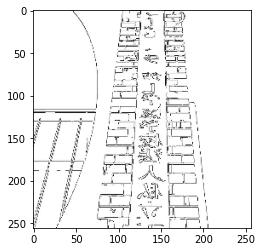

In [10]:
plt.imshow(((load_train_image(randurls[0])[0])+1)/2)
print((((load_train_image(randurls[0])[0])+1)/2).shape)



(256, 256, 3)


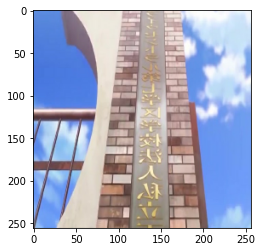

In [11]:
plt.imshow(((load_train_image(randurls[0])[1])+1)/2)
print((((load_train_image(randurls[0])[1])+1)/2).shape)

Cargar datos FINALMENTE

In [12]:
train_dataset=tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset=train_dataset.map(load_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#train_dataset = train_dataset.cache().shuffle(n)
train_dataset=train_dataset.batch(1)

test_dataset=tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset=test_dataset.map(load_test_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset=test_dataset.batch(1)

In [13]:
train_dataset.take(1)

<TakeDataset shapes: ((None, 256, 256, None), (None, 256, 256, None)), types: (tf.float32, tf.float32)>

Diseño de arquitectura

In [14]:
from tensorflow.keras.layers import *
from tensorflow.keras import *

Encoder

In [15]:
def downsample(filters, apply_batchnorm=True):
  result=Sequential()
  
  initializer=tf.random_normal_initializer(0,0.02)
  
  #Capa convolucional
  result.add(Conv2D(filters,
                    kernel_size=4,
                    strides=2,
                    padding="same",
                    kernel_initializer=initializer,
                    use_bias=not apply_batchnorm))
  if apply_batchnorm:
    #Capa de BatchNorm
    result.add(BatchNormalization())
  #Capa de activacion
  result.add(LeakyReLU())
  
  return result

down_model=downsample(1)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 300, 150, 1)


Decoder

In [16]:
def upsample(filters, apply_dropout=False):
  result=Sequential()
  
  initializer=tf.random_normal_initializer(0,0.02)
  
  #Capa convolucional
  result.add(Conv2DTranspose(filters,
                             kernel_size=4,
                             strides=2,
                             padding="same",
                             kernel_initializer=initializer,
                             use_bias=False))
  #Capa de BatchNorm
  result.add(BatchNormalization())
  
  if apply_dropout:
    #Capa de dropout
    result.add(Dropout(0.5))

  #Capa de activacion
  result.add(ReLU())
  
  return result

up_model = upsample(1)
up_result = up_model(down_result)
print (up_result.shape)

(1, 600, 300, 1)


In [17]:
def Generator():
  inputs=tf.keras.layers.Input(shape=[None,None,3])
  ##----------Encoder configuracion -----------------------
  down_stack = [
    downsample(64, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128),                       # (bs, 64, 64, 128)
    downsample(256),                       # (bs, 32, 32, 256)
    downsample(512),                       # (bs, 16, 16, 512)
    downsample(512),                       # (bs, 8, 8, 512)
    downsample(512),                       # (bs, 4, 4, 512)
    downsample(512),                       # (bs, 2, 2, 512)
    downsample(512),                       # (bs, 1, 1, 512)
  ]
  ##----------Decoder configuracion -----------------------
  up_stack = [
    upsample(512, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512),                     # (bs, 16, 16, 1024)
    upsample(256),                     # (bs, 32, 32, 512)
    upsample(128),                     # (bs, 64, 64, 256)
    upsample(64),                      # (bs, 128, 128, 128)
  ]
  
  initializer=tf.random_normal_initializer(0,0.02)
  ##--------------------Ultima Capa--------------------------
  last = Conv2DTranspose(filters=3,
                         kernel_size=4,
                         strides=2,
                         padding="same",
                         kernel_initializer=initializer,
                         activation="tanh") 
  #-----------------------Conectar capas----------
  x=inputs
  ##------Configurar Skip connections-------
  s=[]
  concat = Concatenate()
  
  for down in down_stack:
    x=down(x)
    s.append(x)
    
  s=reversed(s[:-1])
  
  for up,sk in zip(up_stack,s):
    
    x=up(x)
    x=concat([x,sk])
    
  last = last(x)
  
  return Model(inputs=inputs,outputs=last)


In [18]:
generator=Generator()
#ininimg=(((load_train_image(randurls[0])[1])+1)/2)
for ininimg,tginimg in test_dataset.take(1):
  gen_output = generator(((ininimg+1)*255),training=False)

Discriminar

In [19]:
def Discriminator():
  ini=Input(shape=[None,None,3],name="input_img")
  gen=Input(shape=[None,None,3],name="gener_img")
  
  con = concatenate([ini, gen]) #--- CHEKA ESTO!!! //tf.keras.layers.//
  
  initializer = tf.random_normal_initializer(0., 0.02)
  
  down1 = downsample(64, apply_batchnorm=False)(con) # (bs, 128, 128, 64)
  down2 = downsample(128)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256)(down2) # (bs, 32, 32, 256)
  down4 = downsample(512)(down3) # (bs, 34, 34, 256)
  
  last = tf.keras.layers.Conv2D(filters=1,
                                kernel_size=4,
                                strides=1,
                                kernel_initializer=initializer,
                                padding="same")(down4) # (bs, 31, 31, 512)

  return tf.keras.Model(inputs=[ini,gen],outputs=last)


In [20]:
generator = Generator()
discriminator = Discriminator()

Funcion de coste

In [21]:
loss_object=tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [22]:
def discriminator_loss(disc_real_output, disc_generated_output):
  #Diferencias entre os true por ser real y el detectador por el discriminador
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  #Diferencia entre los false por ser generado y el derectado por el discriminador
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [23]:
LAMBDA=100

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss

Checkpoints

In [24]:
import os
generator_optimizer=tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
discriminator_optimizer=tf.keras.optimizers.Adam(2e-4,beta_1=0.5)

checkpoint_prefix = os.path.join(pathc, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
##----------------Linea interesante--------------
#checkpoint.restore(tf.train.lastest_checkpoint(CKPATH)).assert_consumed.()


In [25]:
def generate_images(model, test_input, tar,save_filename=False, display_imgs=True):
  # the training=True is intentional here since
  # we want the batch statistics while running the model
  # on the test dataset. If we use training=False, we will get
  # the accumulated statistics learned from the training dataset
  # (which we don't want)
  prediction = model(test_input, training=True)
  
  if save_filename:
    tf.keras.preprocessing.image.save_img(path+'/output/'+save_filename+'.jpg',(prediction[0]*0.5+0.5))
  
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']
  if display_imgs:
    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      # getting the pixel values between [0, 1] to plot it.
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
  plt.show()

In [26]:
@tf.function 
def train_step(input_image,target):
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:    
  
    output_image=generator(input_image,training=True)
  
    output_gen_discr= discriminator([output_image,input_image],training=True)
  
    output_trg_discr= discriminator([target,input_image],training=True)
  
    discr_loss=discriminator_loss(output_trg_discr,output_gen_discr)
  
    gen_loss=generator_loss(output_gen_discr,output_image,target)
    
    
    generator_grads=gen_tape.gradient(gen_loss,generator.trainable_variables)
  
    discriminator_grads=discr_tape.gradient(gen_loss,discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_grads,generator.trainable_variables))
    
    discriminator_optimizer.apply_gradients(zip(discriminator_grads,discriminator.trainable_variables))
    

In [27]:
from IPython.display import clear_output

def train(dataset, epochs):
  for epoch in range(epochs):
    imgi=0
    for input_image, target in dataset:
      print('epoch'+str(epoch)+" - train:"+str(imgi)+"/"+str(len(tr_urls)))
      imgi+=1
      train_step(input_image, target)
    
      clear_output(wait=True)

    imgi=0
    for inp,tar in test_dataset.take(5):
      generate_images(generator,inp,tar,str(imgi)+"_"+str(epoch),display_imgs=True)
      imgi +=1
      #generate_images(generator,inp,tar)
      
    #Saving checkpoint
    if (epoch+1)%15==0:
      checkpoint.save(file_prefix=checkpoint_prefix)

Entrenar

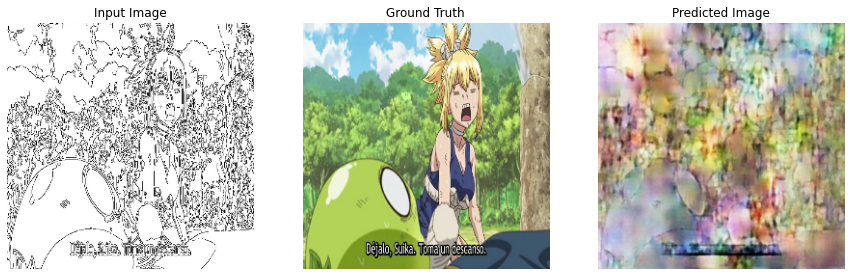

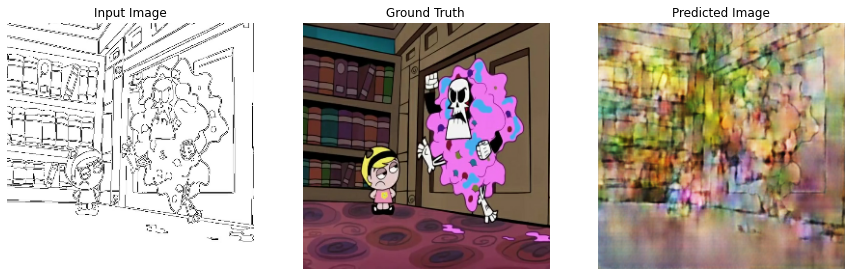

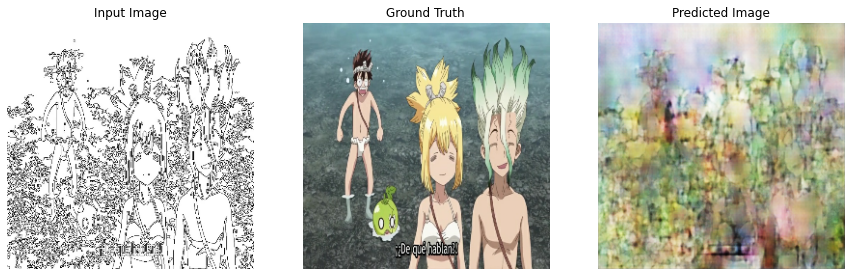

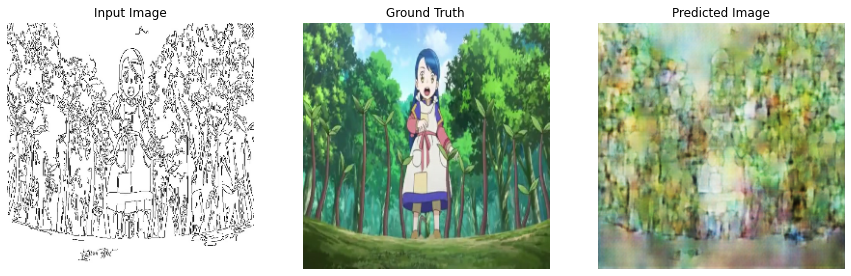

In [ ]:
train(train_dataset, 800)